# Shear profile of A360 using Anacal - Manual

Prakruth Adari, Xiangchong Li, Anja von der Linden\
LSST Science Piplines version: Weekly 2025_14\
Container Size: large

This notebook is a condensed set of code to obtain a shear profile of Abell 360 using Anacal shear measurements. The main steps are:

- Loading the relevant object catalogs (all tracts and patches needed) using the butler
- Loading in Anacal catalogs
- Matching between the two (using RA/DEC + _i_-magnitude)
- Ca
- Load in calibration (using the `gen_hsc_calibration` script)
- Shear profile
  
Most steps start with loading in data from the previous step so each step usually ends with writing data locally, this means we can quickly apply cuts to the same catalog and re-calibrate without having to re-query from the Butler. 

In [2]:
!eups list -s | grep lsst_distrib

lsst_distrib          gc675d380bf+c86a2cdfb1 	current w_2025_14 setup


In [3]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import KDTree
import scipy.interpolate as interpolate
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.stats as stats
import healpy as hp
import pandas as pd
from matplotlib import cm
from astropy.visualization import make_lupton_rgb
from matplotlib.legend_handler import HandlerLine2D
from astropy.table import Table, join, vstack
from astropy.io import fits
# %matplotlib widget

In [4]:
# Familiar stack packages
from lsst.daf.butler import Butler
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
# from lsst.afw.image import Exposure, Image, PARENT
import lsst.sphgeom

# These may be less familiar objects dealing with multi-band data products
from lsst.afw.image import MultibandExposure, MultibandImage

In [5]:
# import lsst.afw.display as afwDisplay
import os, sys

In [41]:
hdir = os.getenv('HOME')
ddir = '/home/a/adari/DATA'
xdir = '/sdf/home/x/xiangchl/Abell360/catalog_v1'

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [10]:
arcsec = 1/60**2

In [11]:
rng = np.random.default_rng()

In [12]:
def showRGB(image, bgr="gri", ax=None, fp=None, figsize=(8,8), stretch=57, Q=10):
    """Display an RGB color composite image with matplotlib.
    
    Parameters
    ----------
    image : `MultibandImage`
        `MultibandImage` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e. keys of the exps dict) indicating what band
        to use for each channel. If `image` only has three filters then this parameter is ignored
        and the filters in the image are used.
    ax : `matplotlib.axes.Axes`
        Axis in a `matplotlib.Figure` to display the image.
        If `axis` is `None` then a new figure is created.
    fp: `lsst.afw.detection.Footprint`
        Footprint that contains the peak catalog for peaks in the image.
        If `fp` is `None` then no peak positions are plotted.
    figsize: tuple
        Size of the `matplotlib.Figure` created.
        If `ax` is not `None` then this parameter is ignored.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    """
    # If the image only has 3 bands, reverse the order of the bands to produce the RGB image
    if len(image) == 3:
        bgr = image.filters
    # Extract the primary image component of each Exposure with the .image property, and use .array to get a NumPy array view.
    rgb = make_lupton_rgb(image_r=image[bgr[2]].array,  # numpy array for the r channel
                          image_g=image[bgr[1]].array,  # numpy array for the g channel
                          image_b=image[bgr[0]].array,  # numpy array for the b channel
                          stretch=stretch, Q=Q)  # parameters used to stretch and scale the pixel values
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
    
    # Exposure.getBBox() returns a Box2I, a box with integer pixel coordinates that correspond to the centers of pixels.
    # Matplotlib's `extent` argument expects to receive the coordinates of the edges of pixels, which is what
    # this Box2D (a box with floating-point coordinates) represents.
    integerPixelBBox = image[bgr[0]].getBBox()
    bbox = Box2D(integerPixelBBox)
    ax.imshow(rgb, interpolation='nearest', origin='lower', extent=(bbox.getMinX(), bbox.getMaxX(), bbox.getMinY(), bbox.getMaxY()))
    if fp is not None:
        for peak in fp.getPeaks():
            ax.plot(peak.getIx(), peak.getIy(), "bx", mew=2)

In [13]:
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
c = 3e5 # km/s

In [14]:
Hz = lambda z : c/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

In [15]:
flux_suffix = '_cModelFlux'

In [16]:
# Load operation rehearsal data
# Can use obs_butler.registry.queryCollections to see available collections

obs_repo = '/repo/main'
# obs_repo = '/LSSTComCam/DP1/defaults'
# obs_collection = 'LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865'
# obs_collection = 'LSSTComCam/runs/nightlyValidation/20241108/d_2024_11_05/DM-47059'
# obs_collection = 'LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128'
# obs_collection = 'LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841'
# obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_04/DM-48556'
# obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_06/DM-48810'
# obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_07/DM-48940'
# obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_08/DM-49029'
# obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_09/DM-49235' # DP1 version
# obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_10/DM-49359'
# obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_11/DM-49472'
# obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_13/DM-49751'
# obs_collection = 'LSSTComCam/runs/DRP/DP1/v29_0_0_rc2/DM-49592'
obs_collection = 'LSSTComCam/runs/DRP/DP1/v29_0_0_rc5/DM-49865'

# obs_collection = 'LSSTComCam/runs/nightlyValidation/20241111/d_2024_11_05/DM-47059'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry

In [17]:
# cluster_coords = (59.48731586, -49.00034946)
cluster_coords = (37.86501659859067, 6.982204815599694)


## Load Butler Data

In [18]:
t_skymap = obs_butler.get('skyMap', skymap='lsst_cells_v1')

In [19]:
# Position of the BCG for A360
ra_bcg = cluster_coords[0]
dec_bcg = cluster_coords[1]

# Looking for all patches in delta deg region around it
delta = 0.5
center = lsst.geom.SpherePoint(ra_bcg, dec_bcg, lsst.geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

ra_range = (ra_min, ra_max)
dec_range = (dec_min, dec_max)
radec = [lsst.geom.SpherePoint(ra_range[0], dec_range[0], lsst.geom.degrees),
         lsst.geom.SpherePoint(ra_range[0], dec_range[1], lsst.geom.degrees),
         lsst.geom.SpherePoint(ra_range[1], dec_range[0], lsst.geom.degrees),
         lsst.geom.SpherePoint(ra_range[1], dec_range[1], lsst.geom.degrees)]

tracts_and_patches = t_skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
print(tp_dict)

{10463: [30, 40, 50, 60, 70, 80, 90, 31, 41, 51, 61, 71, 81, 91, 32, 42, 52, 62, 72, 82, 92, 33, 43, 53, 63, 73, 83, 93, 34, 44, 54, 64, 74, 84, 94], 10704: [0, 1, 2, 3, 4, 5], 10464: [37, 47, 57, 67, 77, 87, 97, 38, 48, 58, 68, 78, 88, 98, 39, 49, 59, 69, 79, 89, 99], 10705: [8, 9]}


In [20]:
tract = t_skymap.findTract(center)
patch = tract.findPatch(center)
tract_id = tract.tract_id
patch_id = patch.getSequentialIndex()
skymap_str = 'lsst_cells_v1'

In [21]:
# Get the data for the first tract listed

deepCoaddTable = np.array(list(obs_registry.queryDatasets('deep_coadd', skymap='lsst_cells_v1', patch=patch_id, tract=tract_id)))

# deepCoaddTable = np.array(list(obs_registry.queryDatasets('deepCoadd_calexp', patch=patch_id, tract=tract_id)))
print(deepCoaddTable)

[DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'lsst_cells_v1', tract: 10463, patch: 61}, run='LSSTComCam/runs/DRP/DP1/v29_0_0_rc5/DM-49865/20250405T193807Z', id=64354743-9166-4b3c-8df3-bac8b7d14097)
 DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'lsst_cells_v1', tract: 10463, patch: 61}, run='LSSTComCam/runs/DRP/DP1/v29_0_0_rc5/DM-49865/20250405T193807Z', id=0a484e82-899e-4d1b-ac0c-e1ce6e18b846)
 DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'lsst_cells_v1', tract: 10463, patch: 61}, run='LSSTComCam/runs/DRP/DP1/v29_0_0_rc5/DM-49865/20250405T193807Z', id=96a3d0aa-c7ed-4ca9-a4e0-789895af66f3)
 DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'z', skymap: 'lsst_cells_v1', tract: 10463, patch: 61}, run='LSSTComCam/runs/DRP/DP1/v29_0_0_rc5/DM-49865/20250405T193807Z', id=0b7d2349-3f48-4e66-b5f3-f6

In [22]:
new_deep_calexps = []
for dct in deepCoaddTable:
    new_deep_calexps.append(obs_butler.get(dct))

bands = [ndc.filter.bandLabel for ndc in new_deep_calexps]
coadds = MultibandExposure.fromExposures(bands, new_deep_calexps)
new_wcs = new_deep_calexps[bands.index('i')].getWcs()

In [23]:
flux_bands = [b+suffix for b in bands for suffix in [flux_suffix, flux_suffix+'Err']]

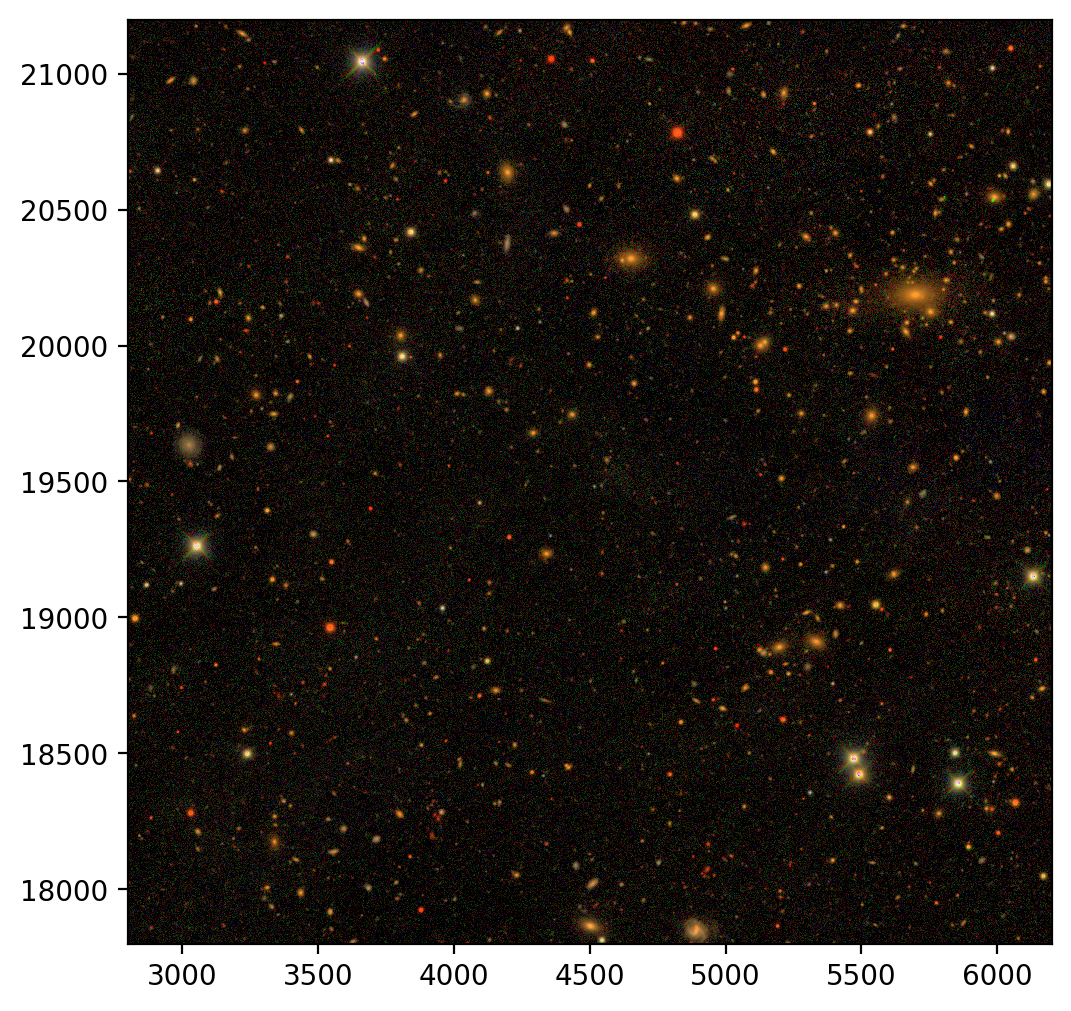

In [222]:
showRGB(coadds.image, bgr='gri', figsize=(6,6))

In [25]:
req_cols = ['coord_ra', 'coord_dec', 'refExtendedness', 'merge_peak_sky', 'detect_isTractInner', 'detect_isDeblendedSource', 'objectId', 'detect_isPrimary',
            'parentObjectId', 'shape_xx', 'shape_xy', 'shape_yy', 'refBand', 'x', 'y', 'patch', 'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_iPSF_flag',
            'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2', 'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_sigma', 'i_blendedness' ] + flux_bands

In [26]:
cluster_tables = []

tids = tp_dict.keys()
# tids = [tract_id]
for tid in tids:
    for pi in tp_dict[tid]:
        cluster_tables.append(obs_butler.get('object_patch', skymap='lsst_cells_v1', patch=pi, tract=tid, 
                                   parameters={"columns":req_cols}))

In [27]:
# cluster_table = pd.concat(cluster_tables)
cluster_table = vstack(cluster_tables, metadata_conflicts='silent')
primary_cluster = cluster_table[cluster_table['detect_isPrimary']]

In [28]:
for b in bands:
    primary_cluster[f'{b}_mag'] = u.nJy.to(u.ABmag, primary_cluster[f'{b}{flux_suffix}'])
    primary_cluster[f'{b}_snr'] = primary_cluster[f'{b}{flux_suffix}']/primary_cluster[f'{b}{flux_suffix}Err']

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [29]:
R2 = 1 - (primary_cluster['i_ixxPSF']+primary_cluster['i_iyyPSF'])/(primary_cluster['shape_xx']+primary_cluster['shape_yy'])
primary_cluster['res'] = R2

In [30]:
primary_cluster.add_index('objectId')

In [31]:
primary_cluster.meta = {'LSST.BUTLER.RUN': 'v29_0_0_rc5/DM-49865'}

In [32]:
primary_cluster.write('cluster_data/abell360_PRECUTS_rc5.fits', format="fits", overwrite=True)

### Load Euclid Data

In [130]:
with fits.open('cluster0.7_pz.fits') as hdul:
    # Assuming data is in the first HDU (if not, change the index as needed)
    data = hdul[1].data

    # Convert the FITS data to an Astropy Table
    euclid_pz = Table(data)


In [131]:
euclid_coords = np.vstack((euclid_pz['right_ascension'], euclid_pz['declination'])).T
euclid_tree = KDTree(euclid_coords)

In [132]:
primary_coords = np.vstack((primary_cluster['coord_ra'], primary_cluster['coord_dec'])).T
primary_tree = KDTree(primary_coords)

In [133]:
euclid_match = euclid_tree.query(primary_coords, k=1)

In [134]:
pz_est = []

for ed, em in zip(*euclid_match):
    if ed < arcsec:
        pz_est.append(euclid_pz[em]['phz_median'])
    else:
        pz_est.append(-99)
        

In [135]:
primary_cluster['pz_euclid'] = pz_est

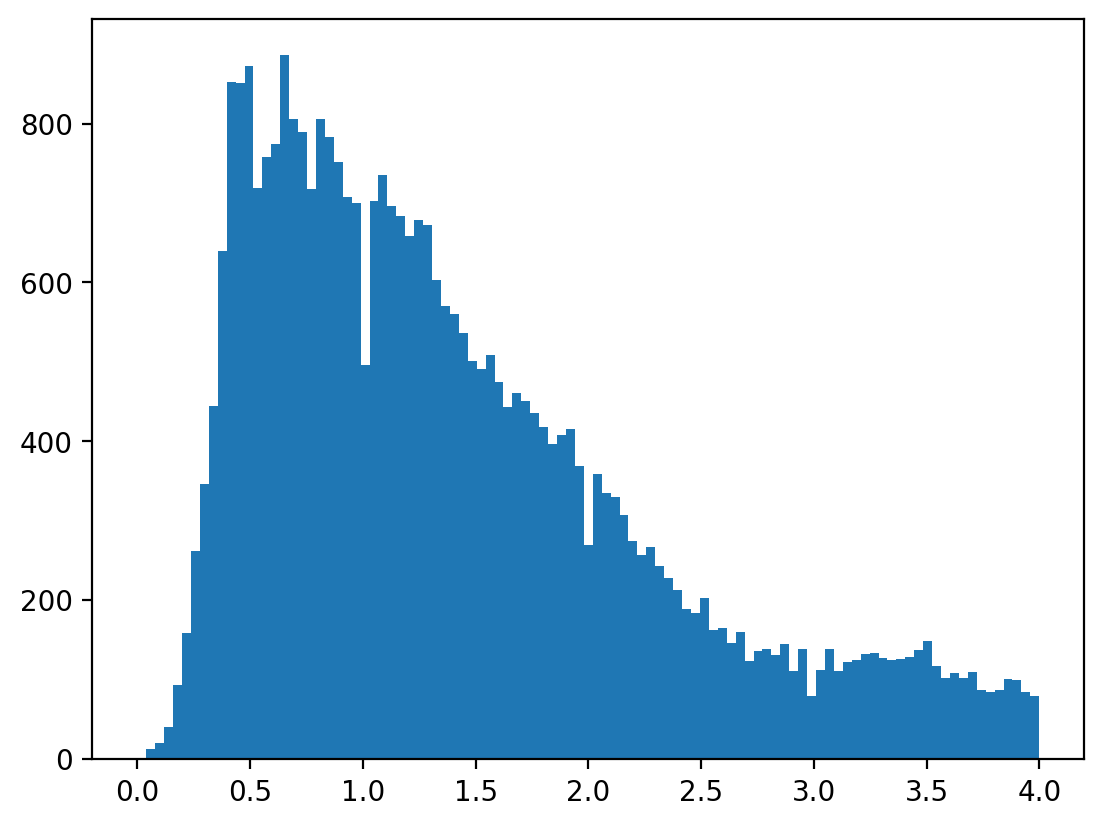

In [136]:
plt.hist(primary_cluster['pz_euclid'], range=(0,4), bins=101);

In [ ]:
# # butler_run = primary_cluster.meta['LSST.BUTLER.RUN']
# primary_cluster.meta = {'LSST.BUTLER.RUN': 'v29_0_0_rc2/DM-49592'}

# primary_cluster['i_snr'] = primary_cluster['i_cModelFlux']/primary_cluster['i_cModelFluxErr']

# R2 = 1 - (primary_cluster['i_ixxPSF']+primary_cluster['i_iyyPSF'])/(primary_cluster['shape_xx']+primary_cluster['shape_yy'])
# primary_cluster['res'] = R2

In [140]:
# Save matched catalog
primary_cluster.write('cluster_data/edfs0.7_cluster_euclidpz_PRECUTS.fits', format="fits", overwrite=True)

## Precuts

In [264]:
# Load in pre-cuts data
with fits.open('cluster_data/abell360_PRECUTS_rc5.fits') as hdul:
        data = hdul[1].data
        table = Table(data)

# # Load in pre-cuts data
# with fits.open('cluster_data/edfs0.7_cluster_euclidpz_PRECUTS.fits') as hdul:
#         data = hdul[1].data
#         table = Table(data)

In [265]:
anacal_tables = []

for tid in tp_dict.keys():
    patches = tp_dict[tid]
    for p in patches:
        ana_table = Table.read(f'/sdf/data/rubin/shared/cluster_commissioning/anacal/{tid}-{p}.fits')
        anacal_tables.append(ana_table)

In [266]:
anacal_table = vstack(anacal_tables)

In [267]:
anacal_mag = 27 - np.log10(anacal_table['flux'] ) *2.5
anacal_table['mag'] = anacal_mag

In [268]:
anacal_coords = np.vstack((anacal_table['ra'], anacal_table['dec'])).T
anacal_tree = KDTree(anacal_coords)

In [269]:
wl_coords = np.vstack((table['coord_ra'], table['coord_dec'])).T
wl_tree = KDTree(wl_coords)

In [270]:
match_dist, match_ndx = anacal_tree.query(wl_coords)

In [271]:
mag_diffs = table['i_mag'] - anacal_table['mag'][match_ndx]
near_match = match_dist < 1.5*arcsec

In [272]:
good_anacal = near_match * (np.abs(mag_diffs) < 0.5)
print(np.sum(good_anacal), len(good_anacal))

51294 293576


In [273]:
table['i_anacal_goodflag'] = good_anacal

In [274]:
# plt.hist(mag_diffs, range=(-2, 5), bins=100, label='All Match')
# plt.hist(mag_diffs[near_match], range=(-2, 2), bins=100, label="Near ($< 1.5''$) Match");
# plt.title("Comcam object $i$ mag - Anacal nearest match $i$ mag")
# plt.legend()

In [278]:
ae1 = anacal_table['fpfs_e1']
ae2 = anacal_table['fpfs_e2']
lct = len(table)

wl_ae1 = np.ones(lct) * -99.
wl_ae2 = np.ones(lct) * -99.

wl_r1 = np.ones(lct) * -99.
wl_r2 = np.ones(lct) * -99.

for i in range(lct):
    if good_anacal[i]:
        wl_ae1[i] = ae1[match_ndx[i]] * anacal_table["wdet"][match_ndx[i]]
        wl_ae2[i] = ae2[match_ndx[i]] * anacal_table["wdet"][match_ndx[i]]
        wl_r1[i] = anacal_table["fpfs_de1_dg1"][match_ndx[i]] * anacal_table["wdet"][match_ndx[i]] + anacal_table["dwdet_dg1"][match_ndx[i]] * anacal_table["fpfs_e1"][match_ndx[i]]
        wl_r2[i] = anacal_table["fpfs_de2_dg2"][match_ndx[i]] * anacal_table["wdet"][match_ndx[i]] + anacal_table["dwdet_dg2"][match_ndx[i]] * anacal_table["fpfs_e2"][match_ndx[i]]

In [279]:
table['anacal_e1'] = wl_ae1
table['anacal_e2'] = wl_ae2
table['anacal_R1'] = wl_r1
table['anacal_R2'] = wl_r2

In [285]:
color_ri = table['r_mag'] - table['i_mag']
color_gi = table['g_mag'] - table['i_mag']

In [286]:
gi_rs = 1.6 - (0.07) * (table['i_mag']-21)
gi_rs_hi = gi_rs + 0.22
gi_rs_low = gi_rs - 0.12

gi_rs_lbl = ((color_gi > gi_rs_low) * (color_gi < gi_rs_hi) * (table['i_mag'] < 23))

ri_rs = 0.5 - (0.02) * (table['i_mag']-21)
ri_rs_hi = ri_rs + 0.05
ri_rs_low = ri_rs - 0.07

ri_rs_lbl = ((color_ri > ri_rs_low) * (color_ri < ri_rs_hi) * (table['i_mag'] < 23))

prak_rs = ri_rs_lbl * gi_rs_lbl

In [287]:
# color_ri = table['r_mag'] - table['i_mag']
# c_rs_hi = 0.6 - (0.1/5.) * (table['r_mag']-19)
# c_rs_low = 0.4 - (0.1/5.)* (table['r_mag']-19)

# celine_rs = ((color_ri > c_rs_low) * (color_ri < c_rs_hi) * (table['r_mag'] < 23))

In [288]:
# Apply cuts
# filt = (table['refExtendedness'] >= 0.5)
# filt &= (table['i_mag'] <= 24.5)
# filt &= (table['i_snr'] >= 10)
# filt &= ~(table['i_hsmShapeRegauss_flag'])
# filt &= (table['i_hsmShapeRegauss_e1']**2 + table['i_hsmShapeRegauss_e2']**2) <= 16
# filt &= table['res'] >= 0.3
# filt &= table['i_blendedness'] <= 0.4
# filt &= (table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < table['i_hsmShapeRegauss_sigma'])
# filt &= table['i_iPSF_flag']==0
# filt &= ~celine_rs
filt &= ~prak_rs
filt &= (table['i_anacal_goodflag'])
# filt &= table['pz_euclid'] > .75
print(f"After cuts: {np.sum(filt)}")

After cuts: 47399


In [289]:
cut_table = table[filt]

In [290]:
cut_table.write('cluster_data/abell360_anacal_POSTCUTS_colorcuts.fits', format="fits", overwrite=True)

## Calibration

In [291]:
postcuts_filename = 'abell360_anacal_POSTCUTS_colorcuts.fits'

In [292]:
with fits.open(f'cluster_data/{postcuts_filename}') as hdul:
    # Assuming data is in the first HDU (if not, change the index as needed)
    data = hdul[1].data

    # Convert the FITS data to an Astropy Table
    wl_table = Table(data)

# Profile

Requires `wl_table` to be defined from the [Calibration](#Calibration) Step.

In [309]:
def anacal_get_tang_cross(cluster, sky_dist, bins, R1, R2, sample_prefac=-1/2, astropy=True, ci_level=.95):
    nb = len(bins) - 1
    tang_avg = np.zeros(nb)
    cross_avg = np.zeros_like(tang_avg)

    tang_err = np.zeros((nb, 2))
    cross_err = np.zeros_like(tang_err)

    bin_rs = []
    for i in range(nb):
        # bin_rs.append(bins[i])
        ndx_filt = (sky_dist > bins[i]) * (sky_dist < bins[i+1])
        bin_rs.append(np.where(ndx_filt)[0])
        if np.sum(ndx_filt) < 1:
            continue
        if astropy:
            sample = cluster[ndx_filt].data.data
        else:
            sample = cluster[ndx_filt]
        sample_t = sample_prefac*sample.real
        sample_x = sample_prefac*sample.imag

        sample_r1 = np.mean(R1[ndx_filt])
        sample_r2 = np.mean(R2[ndx_filt])

        R_correction = (.5 * (sample_r1 + sample_r2)) 
        
        ta = np.mean(sample_t)/R_correction
        xa = np.mean(sample_x)/R_correction
        te = stats.bootstrap([sample_t], np.mean, confidence_level=ci_level).confidence_interval
        xe = stats.bootstrap([sample_x], np.mean, confidence_level=ci_level).confidence_interval
        
        tang_avg[i] = ta
        cross_avg[i] = xa
        tang_err[i] = te/R_correction
        cross_err[i] = xe/R_correction

    return tang_avg, cross_avg, tang_err, cross_err, bin_rs

In [310]:
# cluster_coords = (59.48731586, -49.00034946)
# cluster_coords = (37.86501659859067, 6.982204815599694)
cluster_coords = (37.865017, 6.982205)


In [311]:
source_phi = np.arctan2(wl_table['coord_dec'] - cluster_coords[1], (cluster_coords[0] - wl_table['coord_ra'])*np.cos(np.deg2rad(cluster_coords[1])))
ang_dist = np.sqrt(((wl_table['coord_ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (wl_table['coord_dec'] - cluster_coords[1])**2)
sky_distance = Da(.22) * ang_dist * (np.pi/180)

In [312]:
# trial_shear = g1+1j*g2
trial_shear = wl_table['anacal_e1'] + 1.j*wl_table['anacal_e2']
cl_shear = trial_shear * -1*np.exp(-2j*source_phi)

In [313]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])

In [314]:
shear_cl = anacal_get_tang_cross(cl_shear, sky_distance, bins_mpc, wl_table['anacal_R1'], wl_table['anacal_R2'], sample_prefac=1, astropy=False, ci_level=.68)

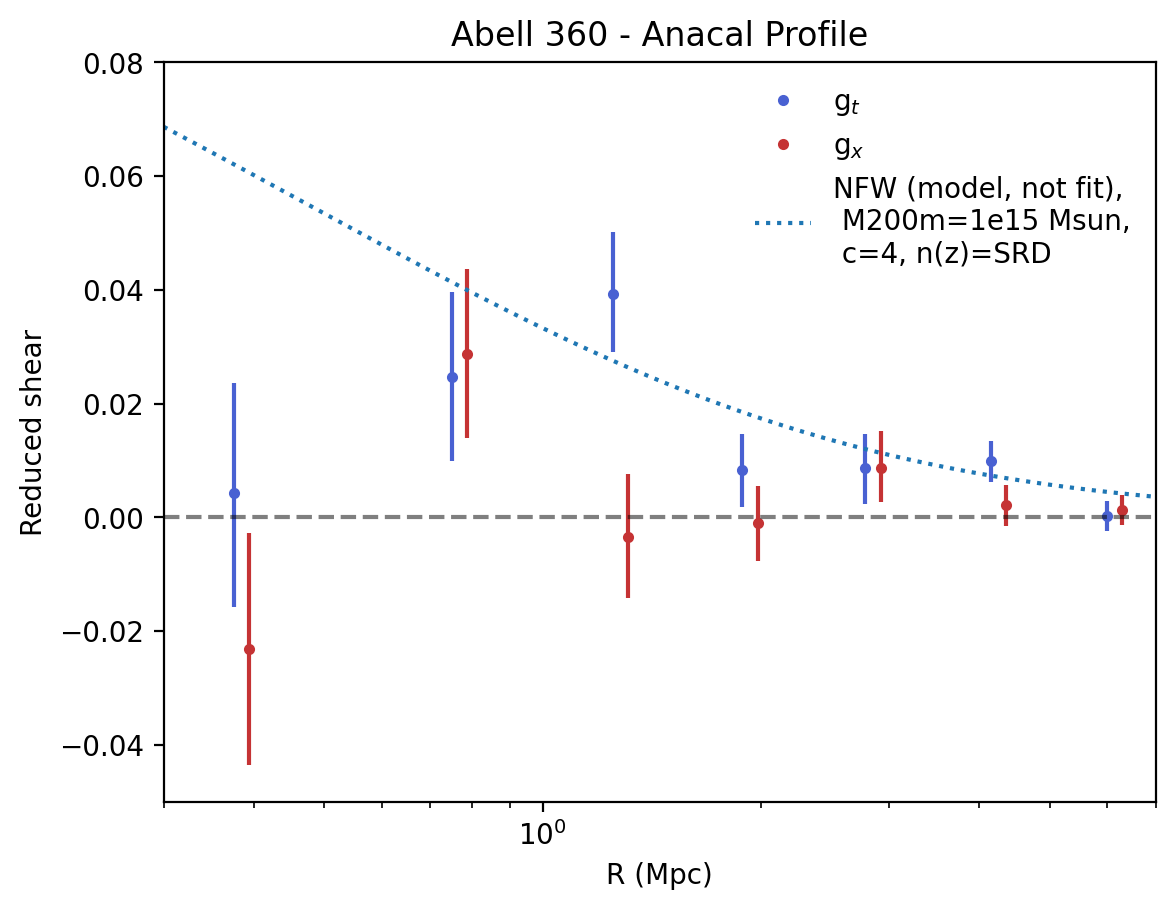

In [327]:
cmap = cm.coolwarm

# plt.plot(sky_distance, reduced_shear, '.')
plt.plot(bin_mids, shear_cl[0], '.', label=r'g$_t$', color=cmap(.05))
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))

plt.plot(1.05*bin_mids, shear_cl[1], '.', label='g$_x$', color=cmap(.95))
plt.vlines(1.05*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))

plt.plot(rproj, gt_z, label='NFW (model, not fit),\n M200m=1e15 Msun,\n c=4, n(z)=SRD', ls=':')

# plt.plot(rbin_mids+.05*rbin_mids, crs_pshear[0], '.-', label='Céline - t', color=cmap(.15), alpha=.2)
# plt.vlines(rbin_mids+.05*rbin_mids, crs_pshear[2][:,0], crs_pshear[2][:,1], color=cmap(0.15), alpha=.2)

plt.semilogx()

plt.axhline(0, ls='--', color='k', alpha=.5)

# plt.errorbar(bin_mids*1.05, cl_plot['gt'], cl_plot['gt_err'], 
#              ls='', marker='.', label='Celine - t', color=cmap(0.15), alpha=.5)
# plt.errorbar(bin_mids*1.15, cl_plot['gx'], cl_plot['gx_err'], 
#              ls='', marker='.', label='Celine - x', color=cmap(0.95), alpha=.5)

# plt.plot(rbin_mids+.15*rbin_mids, crs_pshear[1], '.-', label='Céline - x', color=cmap(.95), alpha=.2)
# plt.vlines(rbin_mids+.15*rbin_mids, crs_pshear[3][:,0], crs_pshear[3][:,1], color=cmap(0.95), alpha=.2)
# plt.title("EDFS Cluster Profile at $z\\approx 0.7$")
plt.title("Abell 360 - Anacal Profile")
# plt.xlim(0.2, 10)
plt.ylim([-0.05,0.08])
plt.xlim([0.3,7])
# plt.ylim(-0.05, 0.15)
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, loc='upper right')

#### CLMM Modeling

In [316]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

In [317]:
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [319]:
moo = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(1.0e15)

# z_cl = gc_object1.z
z_cl = .22

# source properties
# assume sources redshift following a the DESC SRD distribution. This will need updating.

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

rproj = np.logspace(np.log10(0.3),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

In [674]:
with fits.open('CLMM_profile.fits') as hdul:
    data = hdul[1].data
    cl_plot = Table(data)

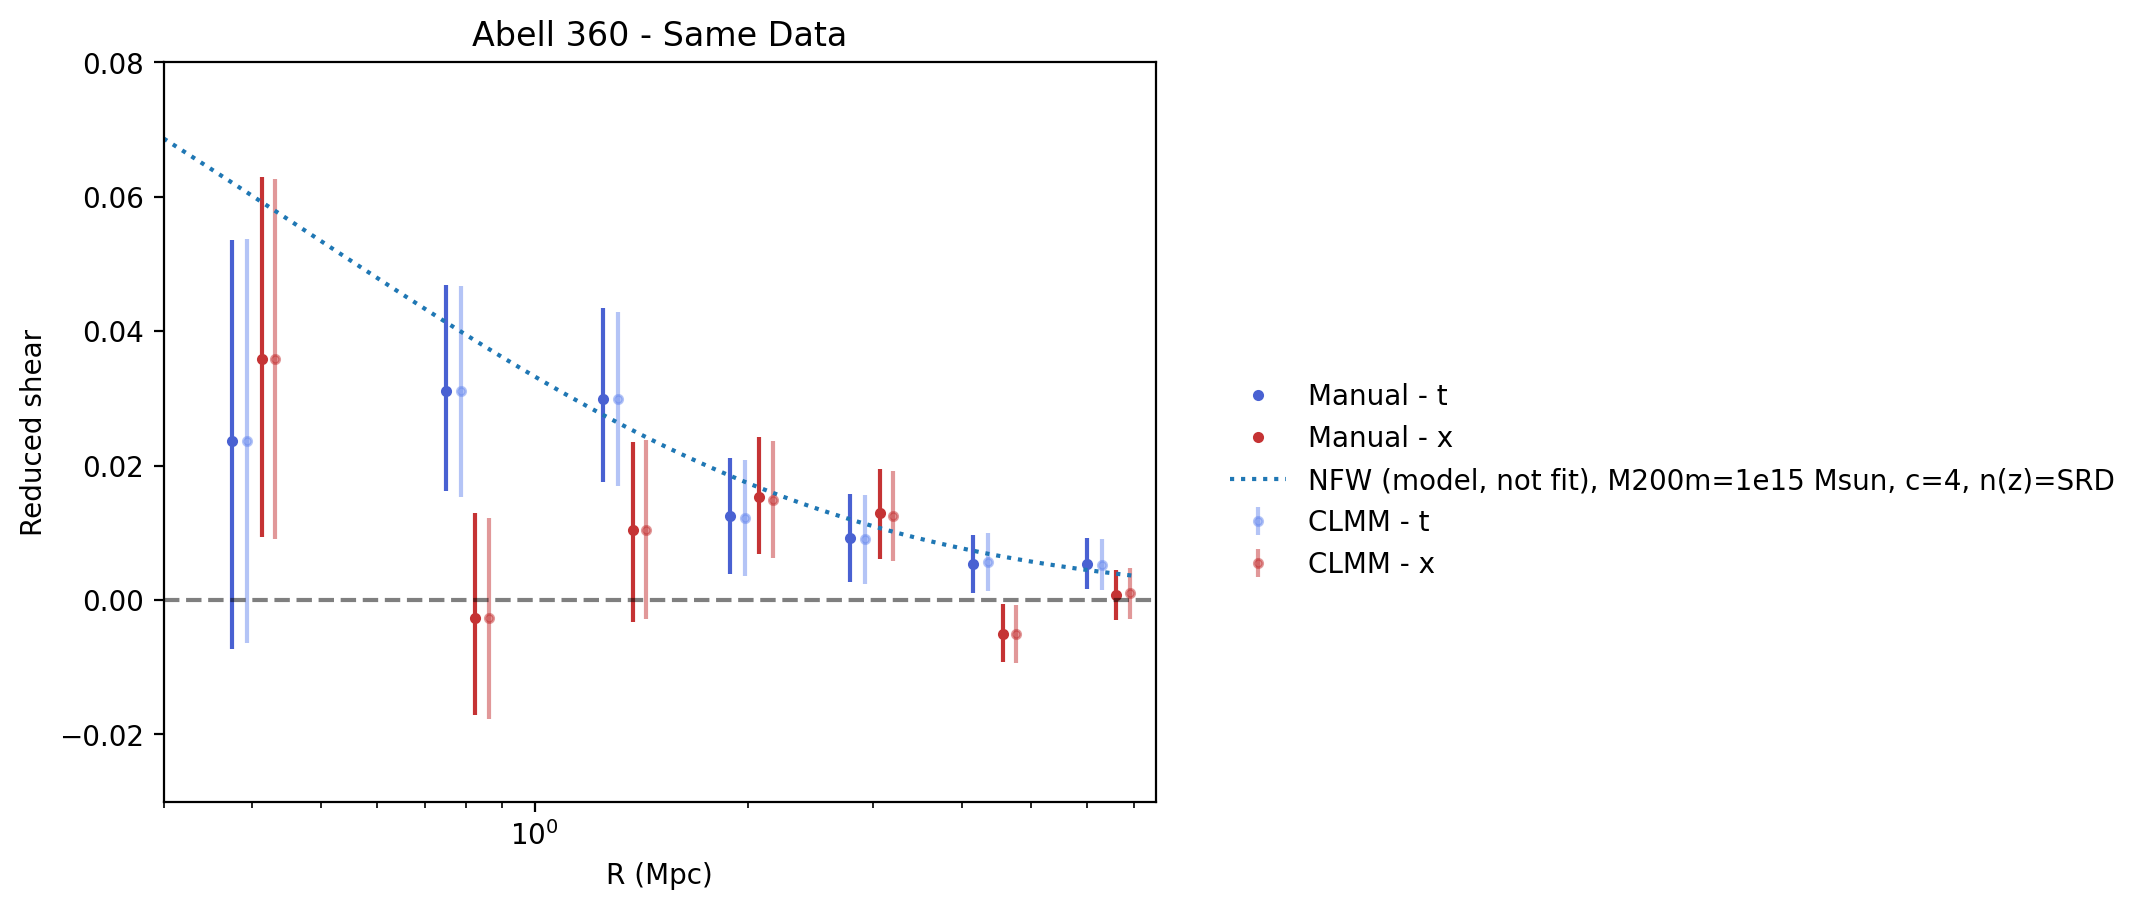

In [675]:
cmap = cm.coolwarm
cmap2 = cm.tab10

plt.plot(bin_mids, shear_cl[0], '.', label='Manual - t', color=cmap(.05))
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))

plt.plot(1.1*bin_mids, shear_cl[1], '.', label='Manual - x', color=cmap(.95))
plt.vlines(1.1*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))

plt.errorbar(bin_mids*1.05, cl_plot['gt'], cl_plot['gt_err'], 
             ls='', marker='.', label='CLMM - t', color=cmap(0.15), alpha=.5)
plt.errorbar(bin_mids*1.15, cl_plot['gx'], cl_plot['gx_err'], 
             ls='', marker='.', label='CLMM - x', color=cmap(0.95), alpha=.5)

plt.plot(rproj, gt_z, label='NFW (model, not fit), M200m=1e15 Msun, c=4, n(z)=SRD', ls=':')


plt.semilogx()
plt.axhline(0, ls='--', color='k', alpha=.5)
plt.title("Abell 360 - Same Data")
# plt.xlim(0.2, 10)
plt.ylim([-0.03,0.08])
plt.xlim([0.3,7.5])
# plt.ylim(-0.05, 0.15)
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, bbox_to_anchor=(1.05, .6))

### CLMM Profile

In [639]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

In [640]:
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

Prepare a CLMM GCData table using the catalog

In [641]:
galcat = GCData()
galcat['ra'] = wl_table['coord_ra']
galcat['dec'] = wl_table['coord_dec']
# galcat['e1'] = e1[to_use]
# galcat['e2'] = e2[to_use]
galcat['e1'] = g1
galcat['e2'] = g2
# galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g
galcat['z'] = np.zeros(len(g1)) # CLMM needs a redshift column for the source, even if not used

In [642]:
ra_bcg = 37.86501659859067
dec_bcg = 6.982204815599694


In [643]:
cluster_id = "Abell 360"
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')

In [644]:
gc_object1.compute_tangential_and_cross_components(add=True);

In [645]:
gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, use_weights=False, gal_ids_in_bins=False);

## Alternatively, angular radial binning (no need for a cosmology then)
# gc_object1.make_radial_profile(bins=bins_deg, bin_units='degrees', add=True, overwrite=True, use_weights=True);


In [646]:
# Check the profile table
gc_object1.profile

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err,n_src,W_l
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0.25,0.38261428357547833,0.5,0.023606130301736215,0.030040040190683563,0.0358578888329995,0.02683647737432472,0.0,0.0,146,146.0
0.5,0.7669026212837617,1.0,0.031035467752181148,0.015650602956473764,-0.002694481871860334,0.014962778251610494,0.0,0.0,587,587.0
1.0,1.2574954263017635,1.5,0.02996653567019372,0.012945480853627404,0.010458412280296637,0.013335866727216934,0.0,0.0,958,958.0
1.5,1.9174413638333772,2.27,0.012238546129942143,0.008607013445962264,0.014937594967608063,0.008660597730776192,0.0,0.0,2074,2074.0
2.27,2.815299601465148,3.3,0.00901770916236597,0.006577157391306692,0.012493809938830525,0.00670789305679313,0.0,0.0,3872,3872.0
3.3,4.215726333667921,5.0,0.005687110977870178,0.004302857713950072,-0.005017666663935826,0.0043057040903883475,0.0,0.0,9226,9226.0
5.0,5.7276756580897015,7.0,0.00523076452861155,0.00380357978888151,0.0009753000679777714,0.0037997713805637255,0.0,0.0,11146,11146.0


Also use CLMM to get a typical model for a cluster at that redshift, assuming the DESC SRD n(z)

In [647]:
moo = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(1.0e15)

z_cl = gc_object1.z

# source properties
# assume sources redshift following a the DESC SRD distribution. This will need updating.

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

rproj = np.logspace(np.log10(0.3),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

/tmp/ipykernel_712/2572233207.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,7])


Text(0.5, 1.0, 'CLMM Profile')

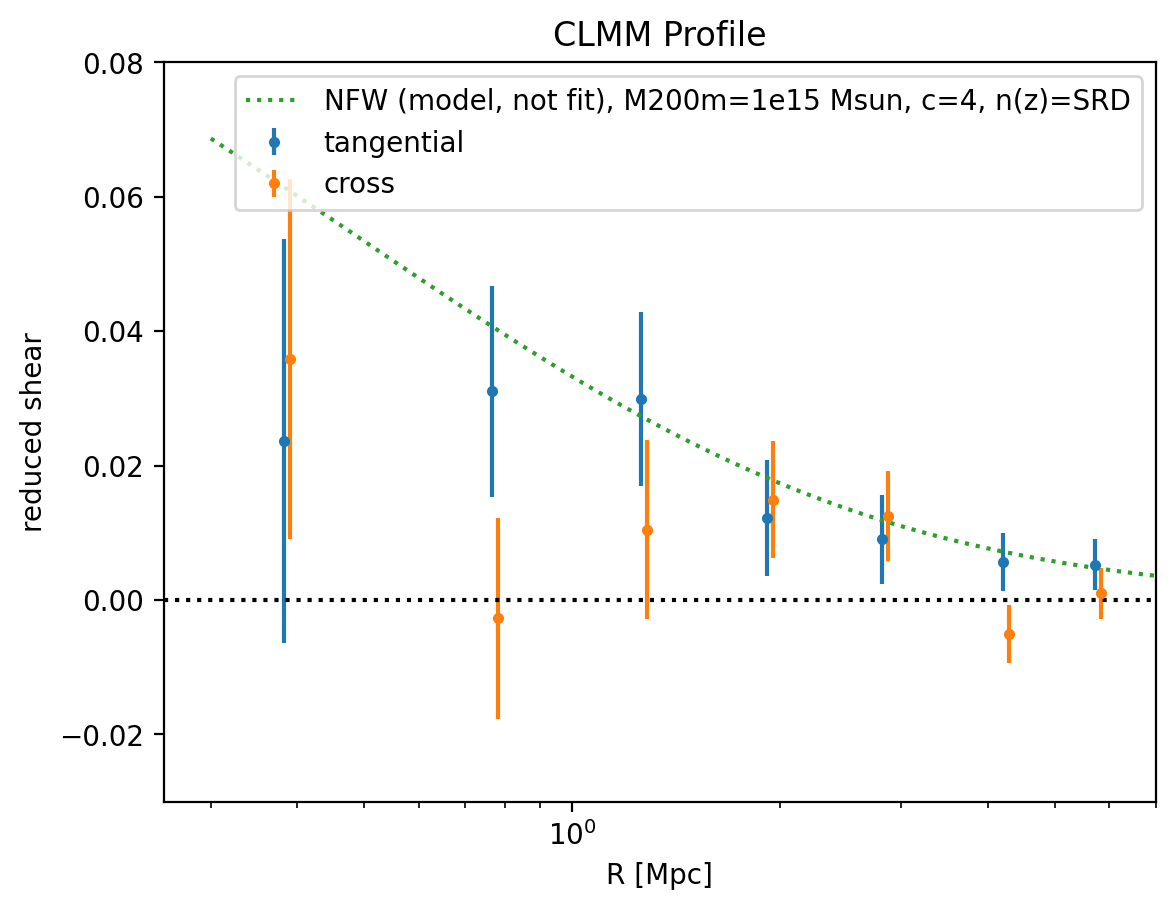

In [648]:
plt.errorbar(gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
             ls='', marker='.', label='tangential')
plt.errorbar(gc_object1.profile['radius']*1.02, gc_object1.profile['gx'], gc_object1.profile['gx_err'], 
             ls='', marker='.', label='cross')
plt.plot(rproj, gt_z, label='NFW (model, not fit), M200m=1e15 Msun, c=4, n(z)=SRD', ls=':')

plt.xscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.08])
plt.xlim([0,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('reduced shear')
plt.legend(loc=1)
plt.title("CLMM Profile")

# Playground

#### Red Sequence Snippet

In [418]:
ang_dist = np.sqrt(((table['coord_ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (table['coord_dec'] - cluster_coords[1])**2)
sub_table = table[(ang_dist < 10*60*arcsec)]

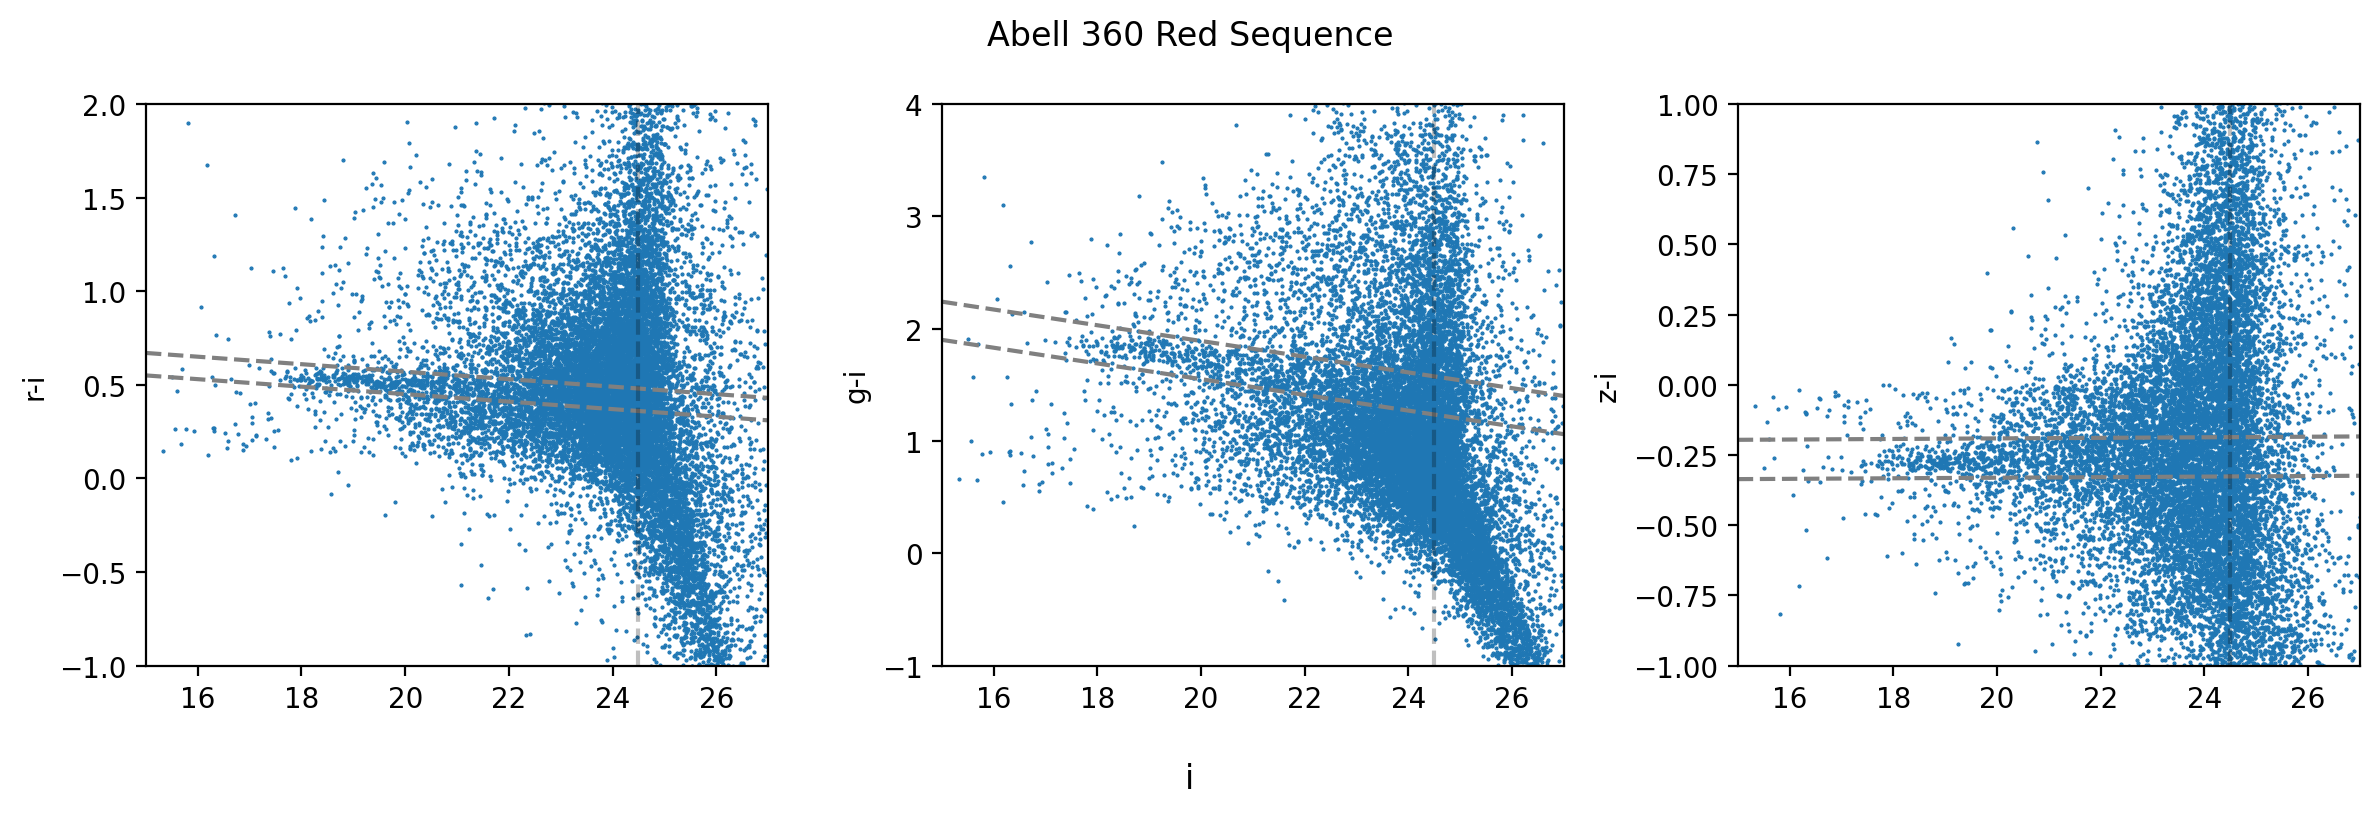

In [490]:
# ang_dist = np.sqrt(((table['coord_ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (table['coord_dec'] - cluster_coords[1])**2)
# sub_table = table[(ang_dist < 10*60*arcsec)]

xs = np.linspace(15, 28, num=1001)

gi_rs_plot = 1.6 - (0.07) * (xs-21)
gi_rs_hi_plot = gi_rs_plot + 0.22
gi_rs_low_plot = gi_rs_plot - 0.12

ri_rs_plot = 0.5 - (0.02) * (xs-21)
ri_rs_hi_plot = ri_rs_plot + 0.05
ri_rs_low_plot = ri_rs_plot - 0.07

zi_rs_plot = -.25 + (0.001) * (xs-21)
zi_rs_hi_plot = zi_rs_plot + 0.06
zi_rs_low_plot = zi_rs_plot - 0.08

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))


ax[0].plot(sub_table['i_mag'], sub_table['r_mag'] - sub_table['i_mag'], '.', markersize=1)
ax[0].plot(xs, ri_rs_hi_plot, '--', color='grey')
ax[0].plot(xs, ri_rs_low_plot, '--', color='grey')

ax[1].plot(sub_table['i_mag'], sub_table['g_mag'] - sub_table['i_mag'], '.', markersize=1)
ax[1].plot(xs, gi_rs_hi_plot, '--', color='grey')
ax[1].plot(xs, gi_rs_low_plot, '--', color='grey')

ax[2].plot(sub_table['i_mag'], sub_table['z_mag'] - sub_table['i_mag'], '.', markersize=1)
ax[2].plot(xs, zi_rs_hi_plot, '--', color='grey')
ax[2].plot(xs, zi_rs_low_plot, '--', color='grey')

fig.suptitle("Abell 360 Red Sequence")
fig.supxlabel("i")
ax[0].set_ylabel("r-i")
ax[1].set_ylabel("g-i")
ax[2].set_ylabel("z-i")

for xx in ax:
    xx.axvline(24.5, ls='--', color='k', alpha=0.25)
    xx.set_xlim(15, 27)
    
ax[0].set_ylim(-1, 2)
ax[1].set_ylim(-1, 4)
ax[2].set_ylim(-1, 1)
plt.tight_layout()